# Импорт библиотек

In [55]:
import numpy as np
from PIL import Image, ImageFont
from pilmoji import Pilmoji
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

# Методы для рисования

In [11]:
def color_diff(rgb1, rgb2):
    """Расстояние между двумя цветами"""
    return np.linalg.norm(rgb1 - rgb2)

In [12]:
def nearest_emoji(rgb, emoji_dict):
    """Найти ближайший по цвету смайлик"""
    return min(emoji_dict.keys(), 
               key=lambda k: color_diff(rgb, emoji_dict[k][0]))

In [15]:
def compare_images(images, labels):
    """Посмотреть две картинки рядом"""
    fig, axes = plt.subplots(ncols=2, dpi=300)
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img)
        ax.set_title(label)
        ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()
    plt.show()

In [25]:
def draw_emojis(filename, width, emoji_dict, disp=True):
    """
    Нарисовать картинку из смайликов-квадратов

    PARAMETERS
    ----------
    filename : str
        | название файла картинки, лежащей в папке input/, 
          которую необходимо нарисовать в виде смайликов
    
    width : int
        | ширина итоговой картинки из смайликов

    emoji_dict : dict
        | специальный словарь смайликов, где каждому
          смайлику соответствует назначенный ему цвет
          в формате numpy-массива из трех значений (RGB)
    
    disp : bool
        | отображать ли результат и логи
    
    RETURNS
    -------
    emoji_array : 2D-ndarray[str]
        | картинка из смайликов в виде 2D numpy-массива
    """
    # Загрузка картинки
    image = Image.open(f'input/{filename}')

    # Вывод размеров картинки
    if disp:
        source_w, source_h = image.size
        print(f'Исходная картинка: {source_h}x{source_w}')
        
    # Уменьшение картинки, преобразование в numpy
    # и сохранение только трех каналов под R, G, B
    image.thumbnail((width, -1))
    image = np.array(image)[:, :, :3]
    
    # Размеры картинки
    img_h, img_w, _ = image.shape
    
    # Вывод размеров картинки
    if disp:
        print(f'Из смайликов:      {img_h}x{img_w}')
    
    # Ближайшая по цветам к смайликам версия картинки
    emoji_image = np.zeros((img_h, img_w, 3), dtype=int)
    # Массив из смайликов
    emoji_array = np.full((img_h, img_w), '', dtype='<U2')
            
    for i in range(img_h):
        for j in range(img_w):
            # Поиск подходящего смайлика и добавление его в массив
            emoji = nearest_emoji(image[i, j], emoji_dict)
            emoji_array[i, j] = emoji
            emoji_image[i, j] = np.rint(emoji_dict[emoji][0])

            # Вывод прогресса
            if disp:
                total_px = img_h * img_w
                current_px = i * img_w + j + 1
                progress = round(current_px / total_px * 100, 2)
                print(f'\rРисование: {progress}%', end='')
    if disp:
        print()
    
    # Вывод результатов
    if disp:
        compare_images(images=(image, emoji_image), 
                       labels=('Уменьшенное разрешение', 
                               'Ближайшие к смайликам цвета'))

    return emoji_array

In [17]:
def load_emoji_dict(name):
    """
    Загрузить словарь смайликов из папки emoji_dicts/
    по его названию
    """
    with open(f'emoji_dicts/{name}.pkl', 'rb') as file:
        emoji_dict = pickle.load(file)
    return emoji_dict

In [18]:
def save_as_text(emoji_array, image_name):
    """
    Сохранить результат (массив смайликов) в файл
    в виде текста

    PARAMETERS
    ----------
    emoji_array : ndarray[str]
        | 2D numpy-массив из смайликов
    
    image_name : str
        | название картинки, текстовый файл для 
          которой будет сохранен в папку output/
    """
    with open(f'output/{image_name}.txt', 'w') as file:
        as_string = '\n'.join(''.join(line) 
                              for line in emoji_array)
        file.write(as_string)

In [56]:
def save_as_image(emoji_array, 
                  image_name, 
                  emoji_resolution, 
                  background_color=None, 
                  disp=False):
    """
    Сохранить результат (массив смайликов) в файл
    в виде картинки формата PNG

    PARAMETERS
    ----------
    emoji_array : ndarray[str]
        | 2D numpy-массив из смайликов
    
    image_name : str
        | название картинки, png-файл для 
          которой будет сохранен в папку output/

    emoji_resolution : int
        | размер каждого смайлика на итоговой картинке
          в пикселях (каждый смайлик рисуется в квадратной 
          области, и этот параметр задает сторону квадрата)

    background_color : (int, int, int) или None или 'dynamic'
        | цвет фона у итоговой картинки:
          - если задан кортеж из трех чисел, фон будет окрашен
            в соответствующий RGB-цвет;
          - если None, фон будет прозрачным
    
    disp : bool
        | выводить ли прогресс сохранения картинки
    """
    # Высота и ширина массива из смайликов
    emojis_h, emojis_w = emoji_array.shape
    # Высота и ширина итоговой картинки из смайликов
    img_h, img_w = np.array(emoji_array.shape) * emoji_resolution

    # Определение цвета фона для разных режимов
    dynamic_mode = False
    if background_color is None:
        img_back = (0, 0, 0, 0)
    else:
        img_back = (*background_color, 255)
    
    # Создание картинки из смайликов
    with Image.new('RGBA', (img_w, img_h), img_back) as image:
        # Шрифт для отображения смайликов
        font = ImageFont.truetype('fonts/arial.ttf', emoji_resolution)

        # Рисование смайликов на картинке
        with Pilmoji(image) as pilmoji:
            for i in range(emojis_w):
                for j in range(emojis_h):
                    # Индексы пикселей в итоговой картинке
                    w, h = i * emoji_resolution, j * emoji_resolution
                    # Отрисовка смайлика
                    pilmoji.text((w, h), emoji_array[j, i], font=font)
                    
                    # Вывод прогресса
                    if disp:
                        total_px = emojis_h * emojis_w
                        current_px = i * emojis_h + j + 1
                        progress = round(current_px / total_px * 100, 2)
                        print(f'\rСохранение изображения: {progress}%', end='')
            if disp:
                print()

    image.save(f'output/{image_name}.png')
    return image

# Рисование

Исходная картинка: 1080x1080
Из смайликов:      50x50
Рисование: 100.0%


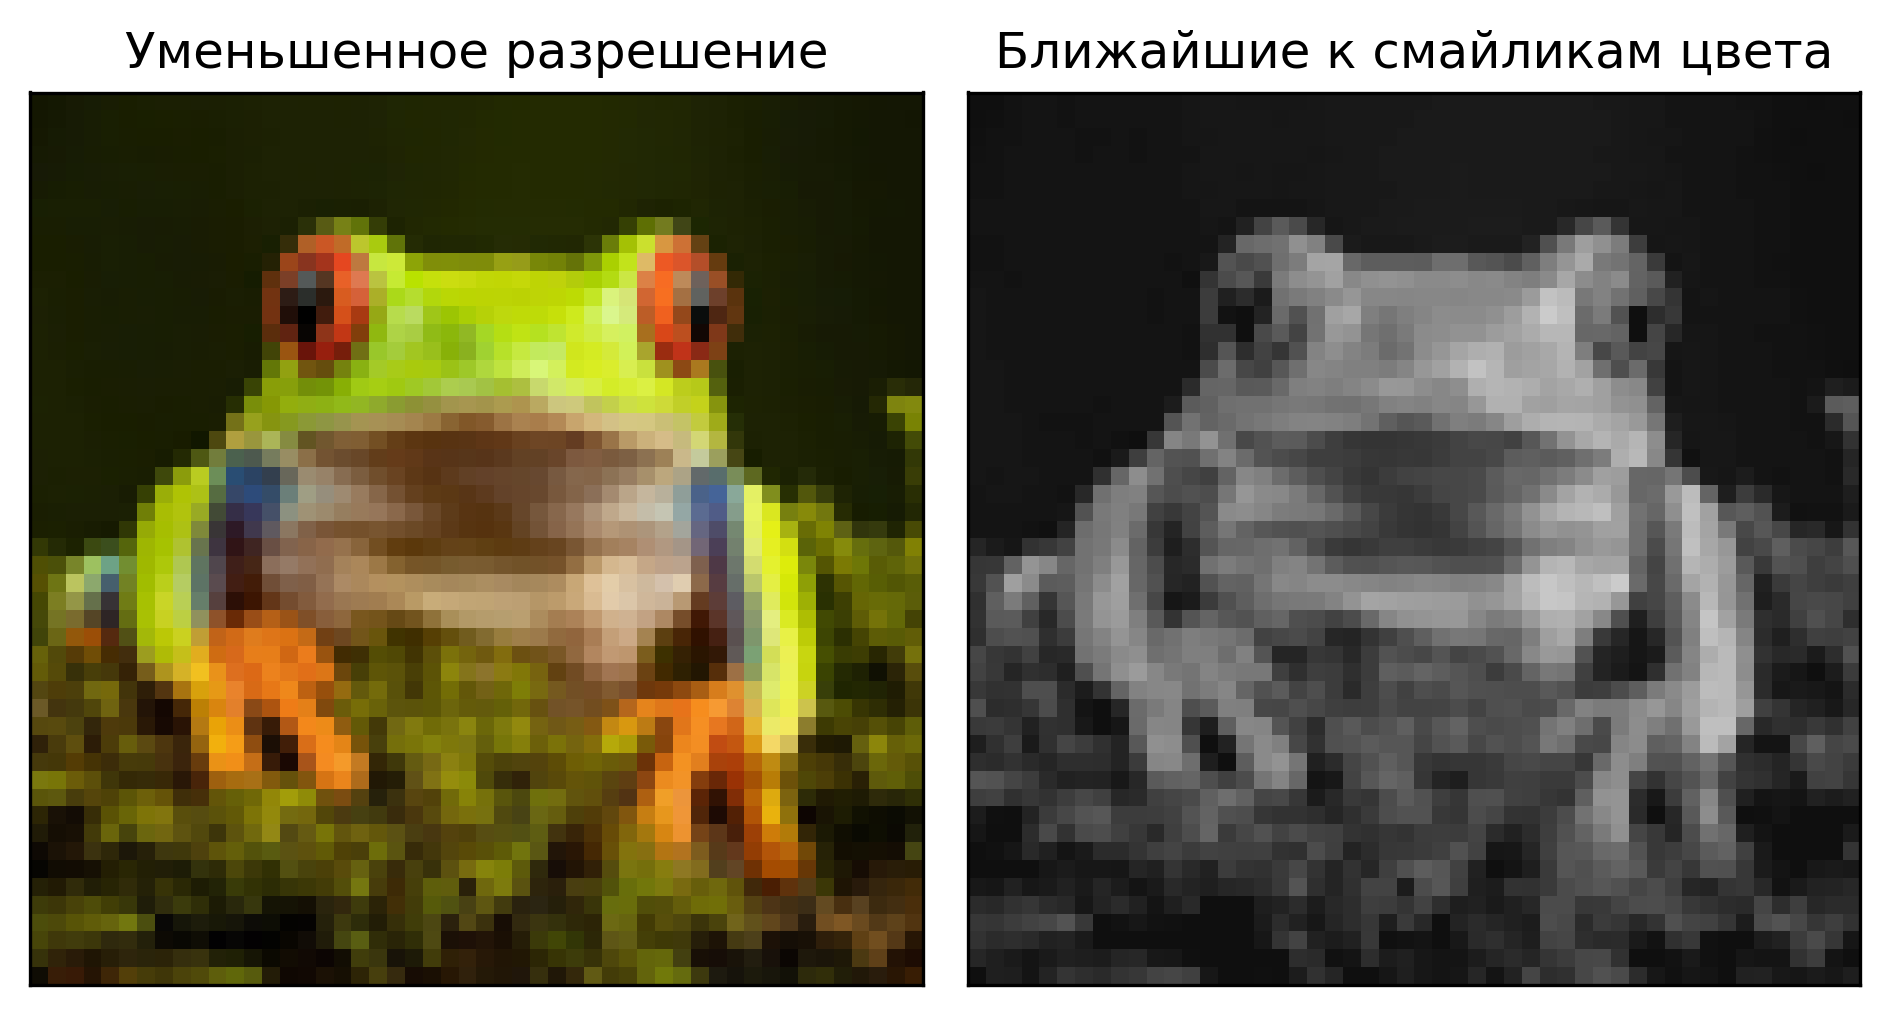

Сохранение изображения: 100.0%
Результаты сохранены в папку output

CPU times: user 15.7 s, sys: 814 ms, total: 16.5 s
Wall time: 26.7 s


In [57]:
%%time

# Загрузка используемого словаря
emoji_dict = load_emoji_dict('classic_black')

# Рисование
emoji_array, resized_img = draw_emojis(filename='frog.png', 
                                       width=50, 
                                       emoji_dict=emoji_dict)

# Сохранение результата
save_as_text(result, 'frog')
save_as_image(result, 'frog', 
              emoji_resolution=50, 
              background_color=None, 
              disp=True)

print('Результаты сохранены в папку output\n')